# Sliding Window And GAN for Explainability (SWAGE)

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
from skimage.transform import resize
from tqdm import tqdm
import math
from scipy.interpolate import Rbf

In [2]:
%matplotlib inline

## Change code below to incorporate your *model* and *input processing*

### Define your model here:

In [3]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras import backend as K

Using TensorFlow backend.


In [4]:
class Model():
    def __init__(self):
        K.set_learning_phase(0)
        self.model = ResNet50()
        self.input_size = (224, 224)
        
    def run_on_batch(self, x):
        return self.model.predict(x)

### Load and preprocess image

In [5]:
from keras.preprocessing import image

In [6]:
def load_img(path):
    img = image.load_img(path, target_size=model.input_size)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

In [7]:
image.load_img

<function keras_preprocessing.image.utils.load_img(path, grayscale=False, color_mode='rgb', target_size=None, interpolation='nearest')>

---

## SWAGE + RISE (for comparison)

In [8]:
def generate_masks(N, s, p1):
    cell_size = np.ceil(np.array(model.input_size) / s)
    up_size = (s + 1) * cell_size

    grid = np.random.rand(N, s, s) < p1
    grid = grid.astype('float32')

    masks = np.empty((N, *model.input_size))

    for i in tqdm(range(N), desc='Generating masks'):
        # Random shifts
        x = np.random.randint(0, cell_size[0])
        y = np.random.randint(0, cell_size[1])
        # Linear upsampling and cropping
        masks[i, :, :] = resize(grid[i], up_size, order=1, mode='reflect',
                                anti_aliasing=False)[x:x + model.input_size[0], y:y + model.input_size[1]]
    masks = masks.reshape(-1, *model.input_size, 1)
    
    return masks

In [9]:
batch_size = 100

def predict(model, inp, masks, N, R_coords):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    
#     for mask, coord in zip(masked, R_coords):
#         plt.figure()
#         plt.imshow(mask)
#         plt.savefig('mask-{}.png'.format(coord))
            
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
    
    return preds

def relevant_regions(preds, c):
    
    R = np.where(np.argmax(preds, axis=1) == c)
    not_R = np.where(np.argmax(preds, axis=1) != c)
    print(R)
    return R, not_R

def calculate_saliency( preds, masks, N):
    
#     print(masks.shape)
#     print(preds.shape)
#     print(*model.input_size)
#     print(N, -1)////////////
#     print(masks.reshape(N, -1).shape)
#     print(preds.T.dot(masks.reshape(N, -1)).shape)
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    
#     print(sal.shape, N, p1)
    sal = sal / N / p1
#     print('sal shape', sal.shape)
    return sal

In [115]:
def explain(model, inp, c):
    
    inp = inp[0]
    # levels
    N = math.floor(inp.shape[0]/10)
    w = math.floor(inp.shape[0]/2)
    S = np.ones((1000, inp.shape[0], inp.shape[1]))
#     print('initial S:', S.shape)
#     print('levels',N)
    R = np.asarray([[0, inp.shape[1], 0, inp.shape[0]]])
    
    for i in range(0, 2):
        print('level:',i)
        tmp = []
        print('R shape:', R.shape)
        for r in range(0, R.shape[0]):
            print('Region', R[r])
            n, masks, R_coords = sliding_mask(inp, R[r])
            preds = predict(model, inp, masks, n, R_coords)
            rel, not_rel = relevant_regions(preds, c)
            print(rel, not_rel)
            
            if len(rel[0]) > 0:
                print('relevant regions', rel)
                sal = calculate_saliency(preds[rel], masks[rel], len(rel[0]))
#                 print(sal.shape)
                S = np.add(S, sal)
    #             print('S:',S.shape)
    #             print('saliency map overlapped with the input')
#                 print('R-coords', R_coords, rel[0].tolist())
                tmp.append(R_coords[rel[0].tolist(),:])
        if len(tmp) > 0:
            R = np.concatenate(tmp, axis=0)
            R = np.unique(R, axis=0)
            print(tmp)
#             R = tmp[0]
        else: break
        print('New region coordinates for level {}:{}'.format(i+1,R))
        
    return S 
        

In [95]:
batch_size = 100

def explain_rise(model, inp, masks, N):
    preds = []
    # Make sure multiplication is being done for correct axes
    masked = inp * masks
    for i in tqdm(range(0, N, batch_size), desc='Explaining'):
        preds.append(model.run_on_batch(masked[i:min(i+batch_size, N)]))
    preds = np.concatenate(preds)
#     print(np.argmax(preds, axis=1))
    sal = preds.T.dot(masks.reshape(N, -1)).reshape(-1, *model.input_size)
    sal = sal / N / p1
    return sal

In [112]:
def sliding_mask(inp, r):
#     print('splitting regions to generate masks')
#     inp = inp[0]
    w = abs(math.floor((r[0] - r[1])/2))
    
#     print('size of image', w)
    masked = []
#     stepSize = math.floor(w/10)
    stepSize=20
#     stepSize=w
    (w_width, w_height) = (w, w) # window size
    R = []
    for x in range(r[0], r[1] - int(w_width/4) , stepSize):
        for y in range(r[2], r[3] - int(w_height/4), stepSize):
            if ((x+w_width > inp.shape[0]) or (y+w_height > inp.shape[1])):
                continue
            mask = np.zeros((inp.shape[0], inp.shape[1]))
            coords = [x, x + w_width, y, y + w_height]
#             mask = generate_mask(inp, coords)
            mask[x:x + w_width, y:y + w_height] = 1
#         
#             print(masked.shape)
            
            masked.append(mask)
            R.append([x, x+w_width, y, y+w_height])
    
    masked = np.array(masked)
#     print(masked.shape)
    masks = masked.reshape(-1, *model.input_size, 1)
#     print(masks.shape)
    return masks.shape[0], masks, np.asarray(R)

In [84]:
def generate_mask( inp, coords):
    n = abs(coords[1]-coords[0])
#     print('number of elements:',n)
#     print(coords[0], coords[1], coords[2], coords[3])
    x = np.random.uniform(coords[0], coords[1], 5)
    y = np.random.uniform(coords[2], coords[3], 5)


    z = [1]*len(x)
    
#     x_mean = np.mean([coords[0],coords[1]])
#     x_var = np.var([coords[0], coords[1]])
#     y_mean = np.mean([coords[2],coords[3]])
#     y_var = np.var([coords[2], coords[3]])
    
#     x = np.random.normal(x_mean,x_var,n)  
#     y = np.random.normal(y_mean,y_var,n)  
#     z = ((x-x_mean)**2+(y-y_mean)**2)
    
#     print(np.min(x),np.max(x))
#     z = x**2+y**2

    ti = np.linspace(0, inp.shape[0], inp.shape[0])
    XI, YI = np.meshgrid(ti, ti)


    # use RBF
    rbf = Rbf(x, y, z, epsilon=2)
    ZI = rbf(XI, YI)
    ZI = ZI/np.max(ZI)
#     plt.figure()
#     plt.imshow(1-ZI)
#     plt.show()
    return (1-ZI)
        
    

13.479120152684219 108.95908628533904
(10,) (10,)
0.9487497496603297 4.999893955838485
[[0.64403609 0.64643812 0.64881045 ... 0.19851158 0.19466869 0.19082257]
 [0.64704183 0.64946444 0.6518575  ... 0.19992165 0.19607228 0.19221973]
 [0.65001821 0.65246133 0.65487507 ... 0.20131281 0.19745702 0.1935981 ]
 ...
 [0.31913169 0.32028531 0.3214146  ... 0.01168342 0.00854942 0.00540785]
 [0.31517516 0.31632192 0.31744449 ... 0.00896754 0.0058421  0.00270905]
 [0.31121594 0.31235593 0.31347184 ... 0.00624142 0.00312453 0.        ]]
0.0 0.8102460256077124


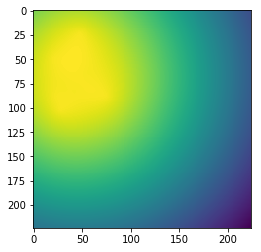

In [201]:
import numpy as np
from scipy.interpolate import Rbf

import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib import cm

# 2-d tests - setup scattered data
# x = np.random.randint(112, 224, 112)+50
x0 = 0
x1 = 112
y0 = 0
y1 = 112
# x_mean = np.mean([x0,x1])
# x_var = np.var([x0,x1])
# y_mean = np.mean([y0,y1])
# y_var = np.var([y0,y1])
# x = np.random.normal(x_mean, x_var, 28) 
# y = np.random.normal(y_mean, y_var, 28)
# print(x_mean, y_mean)
# y = np.random.randint(0, 112, 112)+56
print(np.min(x), np.max(x))
x = np.random.uniform(x0,x1, 10)
y = np.random.uniform(y0,y1, 10)
print(x.shape, y.shape)
# print(np.min(x),np.max(x))
z = [1]*len(x)
# z = np.log((x-x_mean)**2+(y-y_mean)**2)
# print(z)
# z = z/ np.max(z)
ti = np.linspace(0, 224, 224)
XI, YI = np.meshgrid(ti, ti)


# use RBF
rbf = Rbf(x, y, z, epsilon=0.005)
ZI = rbf(XI, YI)
print(np.min(ZI), np.max(ZI))

ZI = ZI/np.max(ZI)
ZI = 1-ZI

print(ZI)
print(np.min(ZI), np.max(ZI))
plt.imshow(ZI)
# plot the result
# n = plt.normalize(-2., 2.)
# plt.subplot(1, 1, 1)
# plt.pcolor(XI, YI, 1-ZI, cmap=cm.jet)
# plt.scatter(x, y, 100, z, cmap=cm.jet)
# plt.title('RBF interpolation - multiquadrics')
# plt.xlim(-2, 2)
# plt.ylim(-2, 2)
# plt.colorbar()


## plt.show()

## Running explanations

In [33]:
def class_name(idx):
    return decode_predictions(np.eye(1, 1000, idx))[0][0][1]

In [34]:
model = Model()

In [107]:
img, x = load_img('bench1.png')

In [76]:
N_rise = 2000
s = 8
p1 = 0.5
masks_rise = generate_masks(2000, 8, 0.5)

Generating masks: 100%|██████████| 2000/2000 [00:06<00:00, 327.02it/s]


In [77]:
s = 8
p1 = 0.5
N_swage, masks_swage = sliding_mask(x)

TypeError: sliding_mask() missing 1 required positional argument: 'r'

In [116]:
p1 = 0.5
sal_swage = explain(model, x, 703)

Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

level: 0
R shape: (1, 4)
Region [  0 224   0 224]


Explaining: 100%|██████████| 1/1 [00:03<00:00,  3.34s/it]


(array([ 1,  2, 28, 34, 35]),)
(array([ 1,  2, 28, 34, 35]),) (array([ 0,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33]),)
relevant regions (array([ 1,  2, 28, 34, 35]),)


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

[array([[  0, 112,  20, 132],
       [  0, 112,  40, 152],
       [ 80, 192,  80, 192],
       [100, 212,  80, 192],
       [100, 212, 100, 212]])]
New region coordinates for level 1:[[  0 112  20 132]
 [  0 112  40 152]
 [ 80 192  80 192]
 [100 212  80 192]
 [100 212 100 212]]
level: 1
R shape: (5, 4)
Region [  0 112  20 132]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(array([], dtype=int64),)
(array([], dtype=int64),) (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24]),)
Region [  0 112  40 152]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(array([], dtype=int64),)
(array([], dtype=int64),) (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24]),)
Region [ 80 192  80 192]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(array([], dtype=int64),)
(array([], dtype=int64),) (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24]),)
Region [100 212  80 192]


Explaining:   0%|          | 0/1 [00:00<?, ?it/s]

(array([], dtype=int64),)
(array([], dtype=int64),) (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]),)
Region [100 212 100 212]


Explaining: 100%|██████████| 1/1 [00:01<00:00,  1.46s/it]

(array([], dtype=int64),)
(array([], dtype=int64),) (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),)


In [89]:
sal_rise = explain_rise(model, x, masks_rise, N_rise)

Explaining: 100%|██████████| 20/20 [03:08<00:00,  9.63s/it]


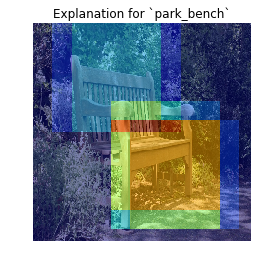

In [117]:

class_idx = 703
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(sal_swage[class_idx], cmap='jet', alpha=0.5)
# plt.colorbar()
plt.show()

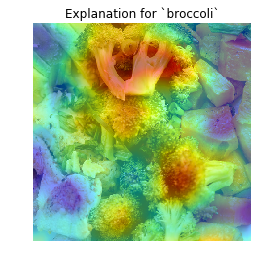

In [90]:
class_idx = 937
plt.title('Explanation for `{}`'.format(class_name(class_idx)))
plt.axis('off')
plt.imshow(img)
plt.imshow(sal_rise[class_idx], cmap='jet', alpha=0.5)
# plt.colorbar()
plt.show()

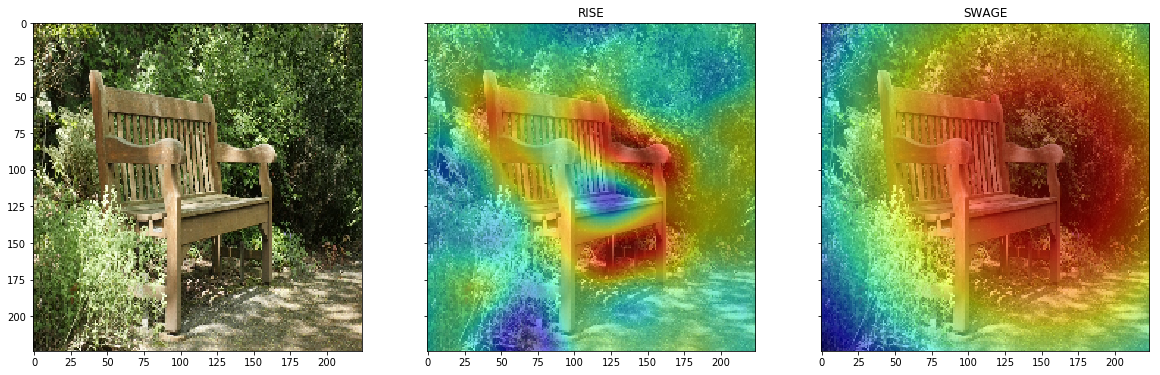

In [74]:
class_idx = 703
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey='row', figsize=(20,20))

ax1.imshow(img)

ax2.imshow(img)
ax2.imshow(sal_rise[class_idx], cmap='jet', alpha=0.5)
ax2.set_title('RISE')
# 2nd suplot
ax3.imshow(img)
ax3.imshow(sal_swage[class_idx], cmap='jet', alpha=0.5)
ax3.set_title('SWAGE')

plt.savefig('explain-bench-kernel.png')

In [76]:
masked = true*masks

masked.shape

(2000, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


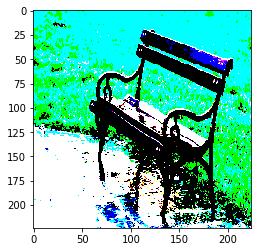

In [49]:
plt.imshow(x.reshape(224,224,3))